In [294]:
# fundamentals
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
from qiskit.circuit.library import U1Gate

# simulator
from qiskit_aer import Aer

# hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

# graphics
from qiskit.visualization import plot_bloch_multivector
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# mathematics
import numpy as np
from scipy.stats import unitary_group

# miscellaneous
import time

In [295]:
## CONSTANTS
NUMBER_OF_BITS = 1
NUMBER_OF_QUBITS = 2 # you will always have two qubits, you will only add more unitary gates to correct for error
MAX_REGISTERS = 5 # number of registers that ceases the simulation

In [296]:
## FUNCTIONS

# creates the entire dynamic circuit
def vmc_circuit(num_qubits, alpha, beta, register_number):
    vmc_circuit = QuantumCircuit(num_qubits, NUMBER_OF_BITS)
    
    # initialize states
    create_random_state(alpha, beta, register_number, vmc_circuit)
    create_plus(vmc_circuit)
    vmc_circuit.barrier()
    
    # add unitaries and CNOTs
    add_gates(vmc_circuit, register_number)

    # add measurement on |+> register
    # if result is |0>, then it is success
    # if result is |1>, thes it is failure and we have to correct the state
    vmc_circuit.measure(1, 0)

    return vmc_circuit


# adds needed number of unitaries and CNOTs
def add_gates(quantum_circuit, register_number):
    number_of_gates_applied_on_register = 2**(register_number - 1) # calculates number of unitaries in register register_number
    for unitary in range(0, number_of_gates_applied_on_register):
         # applying required number of unitaries on the correct register
         quantum_circuit.p(phase, 1)
         # quantum_circuit.unitary(unitary_matrix, [1], label=r"$U_{\varphi}$")
    quantum_circuit.cx(0, 1)
    

# creates starting states |+> everywhere except for the first register
def create_plus(quantum_circuit):
    quantum_circuit.h(1)


# creates initial random qubit state
def create_random_state(alpha, beta, register_number, quantum_circuit):
    norm = np.sqrt(abs(alpha)**2 + abs(beta)**2) # normalization
    state = [alpha / norm, beta / norm]

    # add or initialize this state in circuit
    quantum_circuit.initialize(state, 0)

    # Calculate the Hermitian conjugate (complex conjugate transpose)
    # unitary_conjugate = np.conj(unitary_matrix.T)
    
    # apply hermitian conjugate of unitary required number of times
    num_of_conjugated_unitaries_applied = 2**(register_number - 1) - 1
    for i in range(0, num_of_conjugated_unitaries_applied): # need to add error from previous measurements
        quantum_circuit.p(phase, 0).inverse()
        # quantum_circuit.unitary(unitary_conjugate, [0], label=r"$U_{\varphi}^{\dagger}$")

In [297]:
## FUNCTIONS TO CREATE STATIC RESULTING CIRCUIT THAT WAS SUCCESSFUL IN THE END

# creates the entire static circuit
def vmc_circuit_static(register_number, alpha, beta):
    vmc_circuit = QuantumCircuit(register_number + 1, NUMBER_OF_BITS)
    
    # initialize states
    create_random_state_static(alpha, beta, vmc_circuit)
    create_plus_static(vmc_circuit)
    vmc_circuit.barrier()
    
    # add unitaries and CNOTs and measurements
    add_gates_static(vmc_circuit)

    return vmc_circuit


# adds unitaries, CNOTs and measurements
def add_gates_static(quantum_circuit):
    num_qubits = quantum_circuit.num_qubits
    if num_qubits < 2:
        return

    # unitaries
    number_of_gates_applied_on_register = 1 # you start with one gate applied and then double it for every new register
    # quantum_circuit.unitary(unitary_matrix, [1], label=r"$U_{\varphi}$") # unitary on first register
    quantum_circuit.p(phase, 1) # unitary on first register
    for register in range(2, num_qubits):
        number_of_gates_applied_on_register *= 2
        for unitary in range(0, number_of_gates_applied_on_register):
            # applying required number of unitaries on the correct register
            quantum_circuit.p(phase, register)
            # quantum_circuit.unitary(unitary_matrix, [register], label=r"$U_{\varphi}$")
    
    # CNOTs and measurements
    for qubit in range(1, num_qubits):
        quantum_circuit.cx(quantum_circuit.qubits[0], quantum_circuit.qubits[qubit])
        quantum_circuit.measure(quantum_circuit.qubits[qubit], 0)


def create_plus_static(quantum_circuit):
    num_qubits = quantum_circuit.num_qubits
    for qubit in range(1, num_qubits):
        quantum_circuit.h(quantum_circuit.qubits[qubit])


# creates initial random qubit state
def create_random_state_static(alpha, beta, quantum_circuit):
    norm = np.sqrt(abs(alpha)**2 + abs(beta)**2) # normalization
    state = [alpha / norm, beta / norm]
    
    # add or initialize this state in circuit
    quantum_circuit.initialize(state, 0)

In [298]:
# FUNCTIONS TO RUN SIMULATIONS
def qasm_simulation(qc):
    qasm_simulator = Aer.get_backend("qasm_simulator")
    transpiled_qc = transpile(qc, qasm_simulator)
    result = qasm_simulator.run(transpiled_qc, shots=shots).result()
    return result

def statevector_simulation(qc):
    statevector_simulator = Aer.get_backend("statevector_simulator")
    transpiled_qc = transpile(qc, statevector_simulator)
    result = statevector_simulator.run(transpiled_qc, shots=shots).result()
    return result

In [299]:
# create probability amplitudes for initial state
alpha, beta = np.random.rand(2) + 1j * np.random.rand(2)

# create phase for random unitary U(1) you want to apply on initial state |\psi>
phase = np.random.uniform(0, 2 * np.pi)
# unitary_matrix = unitary_group.rvs(2) # generates random 2x2 unitary

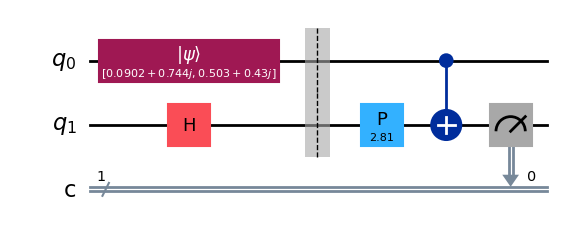

[{'0': 1}]


In [300]:
## MEASUREMENT SIMULATION
# with dynamic creation of circuits

# create initial circuit
register_number = 1
qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

shots = 1 # you have only one measurement and based on its success you are either expanding circuit or not
list_of_results = []
while register_number <= MAX_REGISTERS:    
    result = qasm_simulation(qc)
    counts = result.get_counts()
    list_of_results.append(counts)

    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(qc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)

    # if the result of measurement is |0>, we can end the loop, because U_{\varphi} is successfully applied on initial state \psi
    if "0" in counts:
        break

    # create new circuit that simulates the unsuccessful result of previous measurement (i.e. |1>)
    register_number += 1
    qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)
    
# print list of results for you circuits
print(list_of_results)

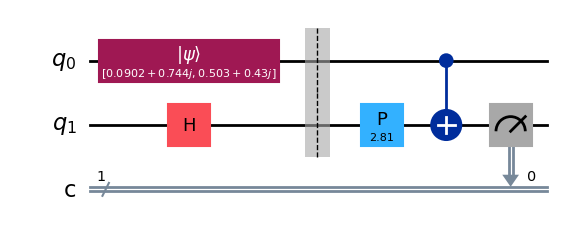

In [301]:
# draw the entire circuit in one piece
qc_resulting = vmc_circuit_static(register_number, alpha, beta)
qc_resulting.draw(output='mpl', fold=-1)

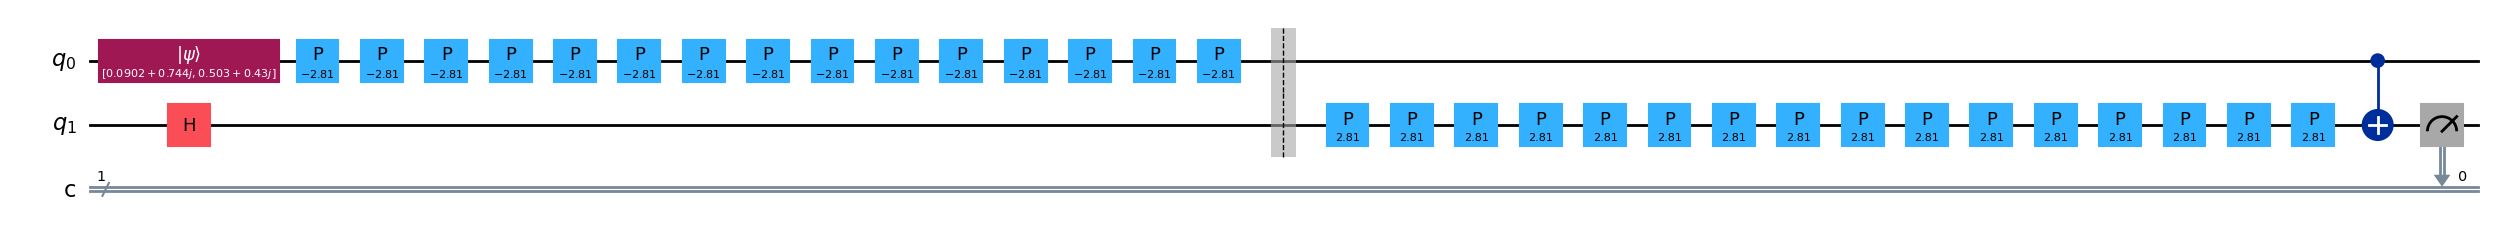

measuring: |1>
measuring: |0>
measuring: |0>
measuring: |1>
measuring: |0>


In [302]:
## STATEVECTOR SIMULATION
# with dynamic creation of circuits

# create initial circuit
register_number = 1
qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

norm = np.sqrt(abs(alpha)**2 + abs(beta)**2)
initial_state = [alpha / norm, beta / norm]

register_number = 1
shots = 1 # you have only one measurement and based on its success you are either expanding circuit or not
list_of_states = []
list_of_full_states = []
list_of_measured_states = []
while register_number <= MAX_REGISTERS:    
    result = statevector_simulation(qc)
    statevector = result.get_statevector()
    partial_vector = partial_trace(DensityMatrix(statevector), [1])
    measured_state = partial_trace(DensityMatrix(statevector), [0])
    list_of_states.append(partial_vector)
    list_of_full_states.append(result.get_statevector())
    list_of_measured_states.append(measured_state)

    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(qc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)
    
    # create new circuit that simulates the unsuccessful result of previous measurement (i.e. |1>)
    register_number += 1
    qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

zerozero = DensityMatrix.from_label('0') # creates |0><0|
oneone =  DensityMatrix.from_label('1') # creates |1><1|
for state in list_of_measured_states:
    if (abs(state_fidelity(state, zerozero) - 1) < 0.01): # there some rounding errors
        print("measuring: |0>")
    else:
        print("measuring: |1>")

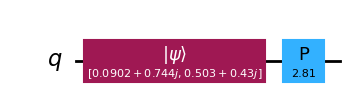

In [303]:
# check fidelity
# in case of measuring |0>, we should get U_{\varphi}|\psi> = what remains in space 0 after measurement
# in case of measuring |1>, we should get U_{-N*\varphi}|\psi> = what remains in space 1 after measurement (N = 2**num_of_registers - 1)

# prepare transformed state U_{\varphi}|\psi>
qc_uphi = QuantumCircuit(1)
create_random_state_static(alpha, beta, qc_uphi)
qc_uphi.p(phase, 0)
qc_uphi.draw(output='mpl')

In [309]:
# calculate fidelity for successful measurement
uphi_initial_state = DensityMatrix.from_instruction(qc_uphi)
for measurement in range(len(list_of_measured_states)):
    if abs(state_fidelity(list_of_measured_states[measurement], zerozero) - 1) < 0.01: # if measurement is |0><0|
        print("Fidelity between initially transformed state and state after measuring |0><0|: " + 
              str(state_fidelity(uphi_initial_state, list_of_states[measurement])))

Fidelity between initially transformed state and state after measuring |0><0|: 1.0000000000000004
Fidelity between initially transformed state and state after measuring |0><0|: 1.0000000000000009
Fidelity between initially transformed state and state after measuring |0><0|: 1.0000000000000009


In [306]:
# prepare list of states U_{-N\varphi}|\psi>
list_of_inversely_transformed_initial_state = []
for register in range(MAX_REGISTERS + 1): # you need one additional circuit because you are applying zero gate in your first circuit
    num_of_inversed_phase_gates = 2**register - 1
    qc_uphi_inversed = QuantumCircuit(1)
    create_random_state_static(alpha, beta, qc_uphi_inversed)
    for i in range(num_of_inversed_phase_gates):
        qc_uphi_inversed.p(phase, 0).inverse()

    # #draw circuits
    # # Clear the previous output and display the updated circuit
    # clear_output(wait=True)
    # display(qc_uphi_inversed.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # # Pause for 1 second to simulate real-time update
    # time.sleep(1)

    # save states
    uphi_inversed_initial_state = DensityMatrix.from_instruction(qc_uphi_inversed)
    list_of_inversely_transformed_initial_state.append(uphi_inversed_initial_state)

In [307]:
# calculate fidelity for failed measurement
uphi_initial_state = DensityMatrix.from_instruction(qc_uphi)
for measurement in range(len(list_of_measured_states)):
    if abs(state_fidelity(list_of_measured_states[measurement], oneone) - 1) < 0.01: # if measurement is |0><0|
        # you have to use the following circuit, because in the first circuit you are not applying any gate on initial state
        # only in the second circuit you are applying one inversed phase gate and so on so it is all shifted by one circuit
        print("Fidelity between initially inversely transformed state and state after measuring |1><1|: " + 
              str(state_fidelity(list_of_inversely_transformed_initial_state[measurement + 1], list_of_states[measurement])))

Fidelity between initially inversely transformed state and state after measuring |1><1|: 1.0000000000000004
Fidelity between initially inversely transformed state and state after measuring |1><1|: 0.9999999999999996


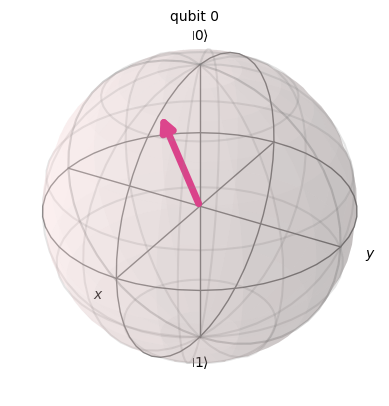

In [265]:
plot_bloch_multivector(initial_state)

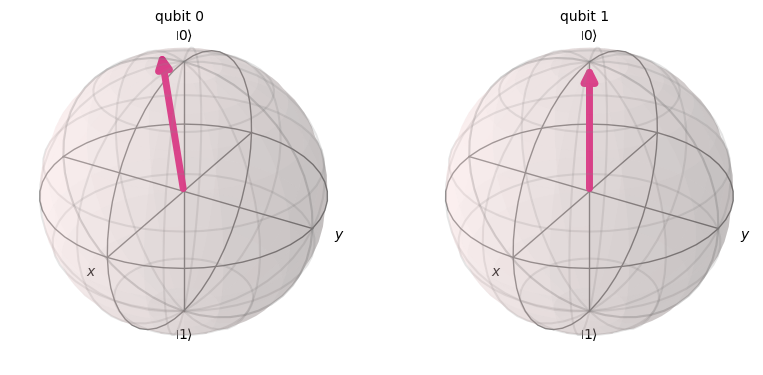

In [279]:
plot_bloch_multivector(list_of_full_states[0])

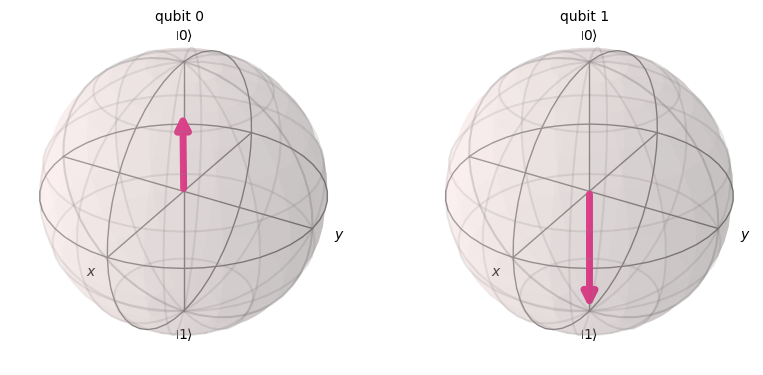

In [280]:
plot_bloch_multivector(list_of_full_states[1])

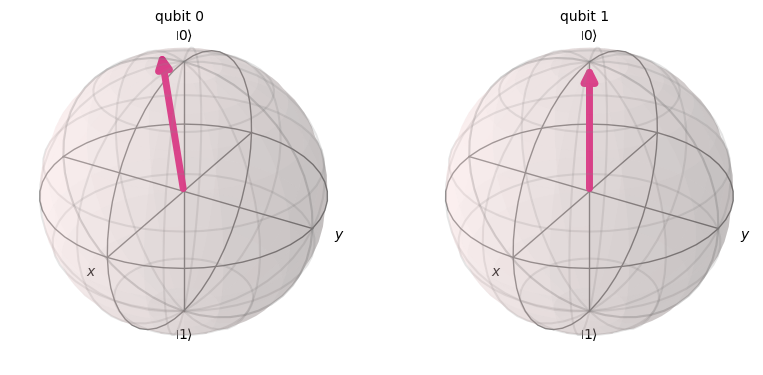

In [281]:
plot_bloch_multivector(list_of_full_states[2])

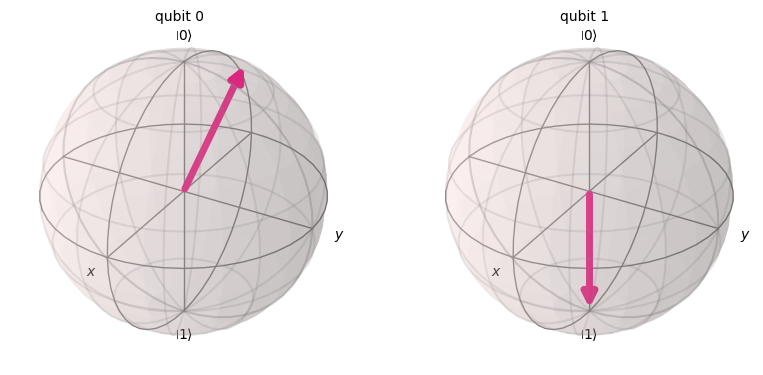

In [282]:
plot_bloch_multivector(list_of_full_states[3])

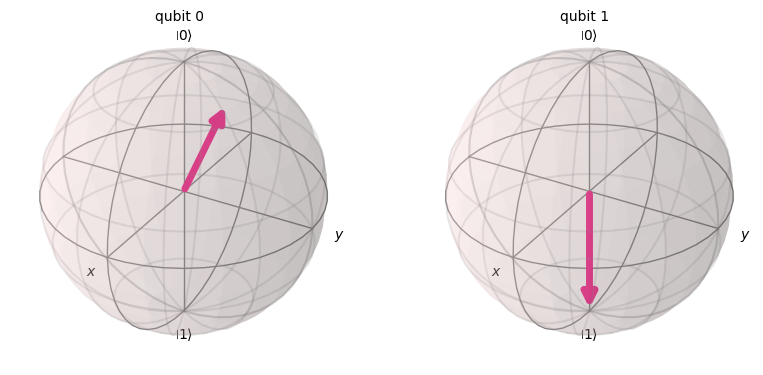

In [283]:
plot_bloch_multivector(list_of_full_states[4])

In [20]:
## RUN ON HARDWARE

# preparation
backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

# sampler
sampler = Sampler(backend)

# prepare first circuit
register_number = 1 # in the beginning you start with only one register (or the first one)
qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, unitary_matrix, register_number)

shots = 1 # you have only one measurement and based on its success you are either expanding circuit or not
list_of_jobs = []
list_of_results = []
list_of_qcs = []
list_of_transpiled_qcs = []
# ibm_brisbane supports for_loop
for register_number in range(1, MAX_REGISTERS + 1):
    # need to transpile every time
    transpiled_qc = pm.run(qc)
    list_of_transpiled_qcs.append(transpiled_qc)
    list_of_qcs.append(qc)

    # run job
    job = sampler.run([transpiled_qc], shots=shots)
    job_id = job.job_id()
    list_of_jobs.append(job_id)
    
    job = service.job(job_id)
    result = job.result()[0]
    data = result.data['c']
    counts = data.get_counts() # c is the name of classical register of qc
    list_of_results.append(counts)

    # if the result of measurement is |0>, we can end the loop, because U_{\varphi} is successfully applied on initial state \psi
    if "0" in counts:
        break

    # create new circuit that simulates the unsuccessful result of previous measurement (i.e. |1>)
    qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, unitary_matrix, register_number)

print("List of job ids: ", list_of_jobs)
print("List of results: ", list_of_results)
print("List of qcs: ", list_of_qcs)
print("List of transpiled qcs: " + str(list_of_transpiled_qcs))

List of job ids:  ['cy8ef6w9b62g008hygkg', 'cy8efc501rbg008jh8zg', 'cy8efyz7v8tg008fnteg', 'cy8egja9b62g008hygt0']
List of results:  [{'1': 1}, {'1': 1}, {'1': 1}, {'0': 1}]
List of qcs:  [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2AB4011F0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2AA400230>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2ABC5C200>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2A8BCDF40>]
List of transpiled qcs: [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2ABB7BD10>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2AA400290>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2A8F4FB60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2AA6F9640>]


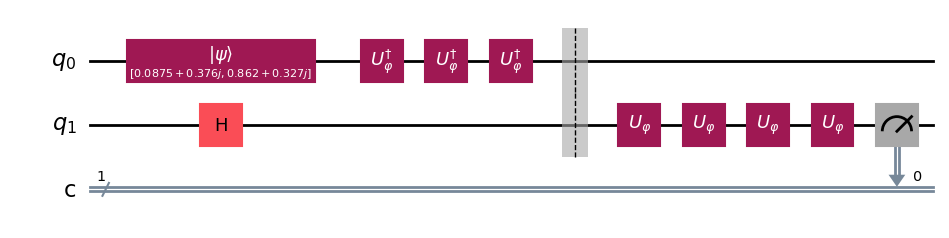

In [24]:
# draw all circuits from hardware
for qc in list_of_qcs:
    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(qc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)

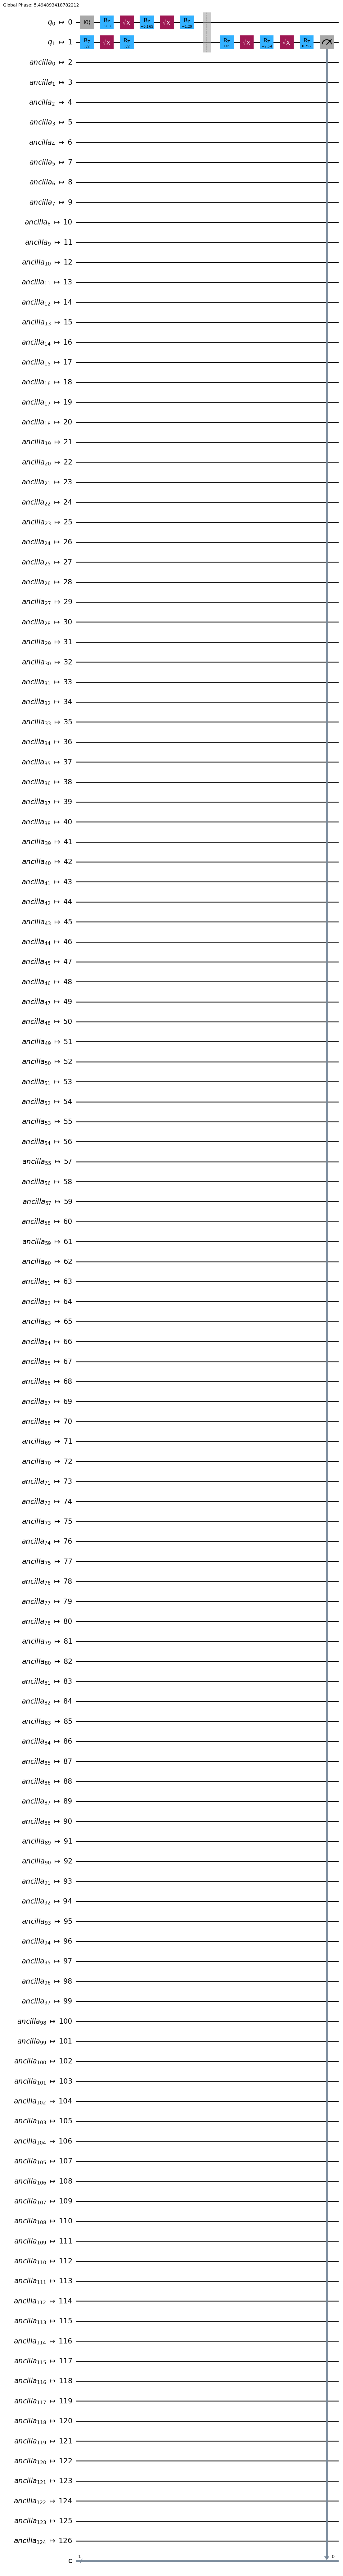

In [25]:
# draw all transpiled circuits from hardware
for tqc in list_of_transpiled_qcs:
    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(tqc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)

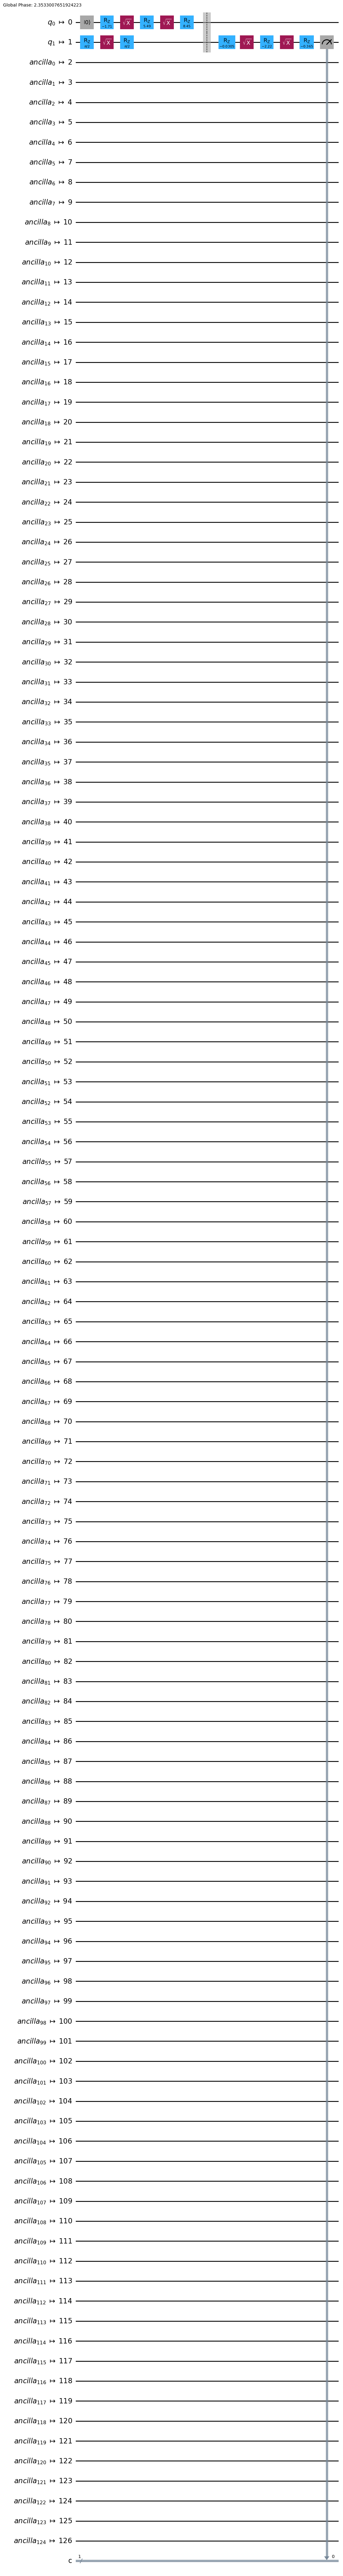

In [26]:
list_of_transpiled_qcs[0].draw(output='mpl', fold=-1)

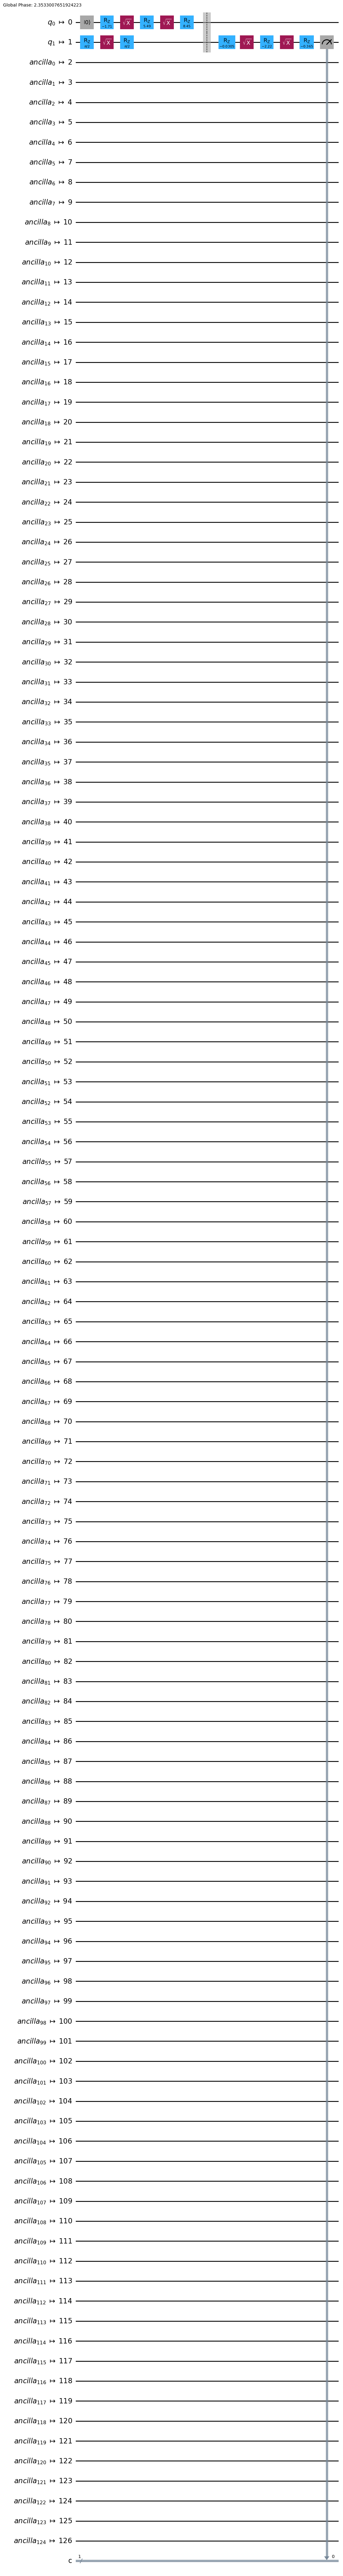

In [27]:
list_of_transpiled_qcs[1].draw(output='mpl', fold=-1)

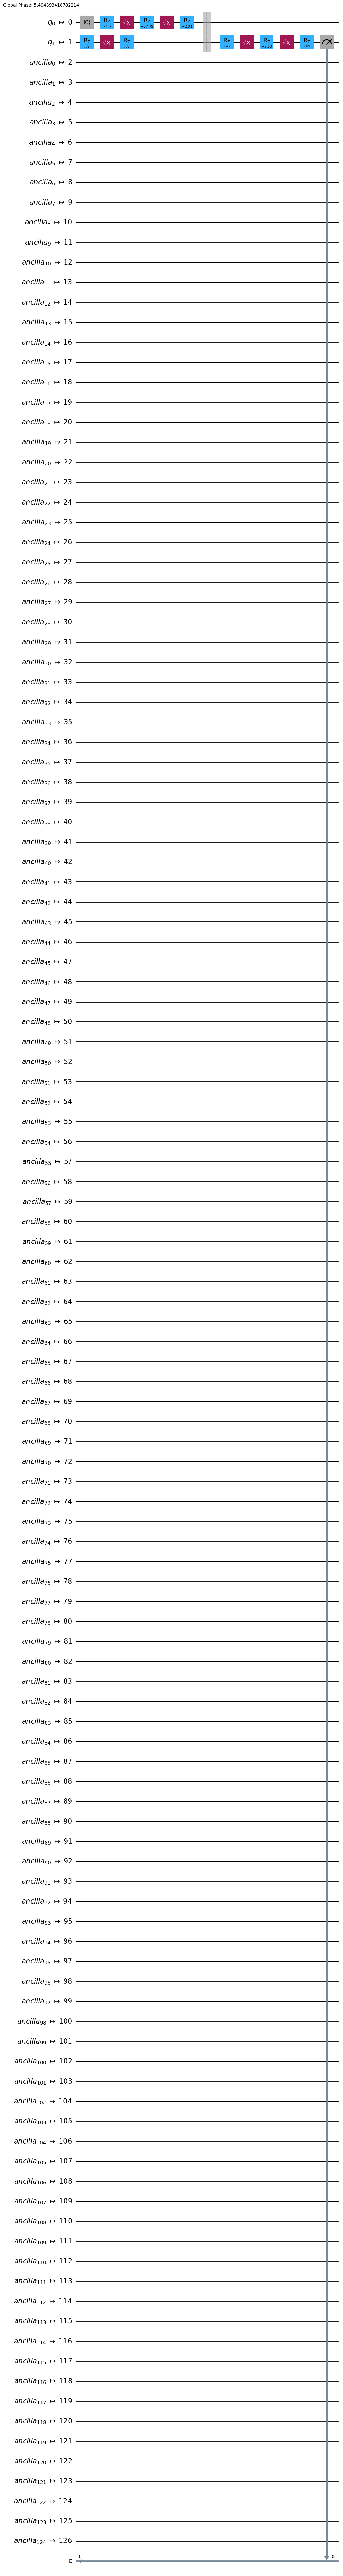

In [28]:
list_of_transpiled_qcs[2].draw(output='mpl', fold=-1)

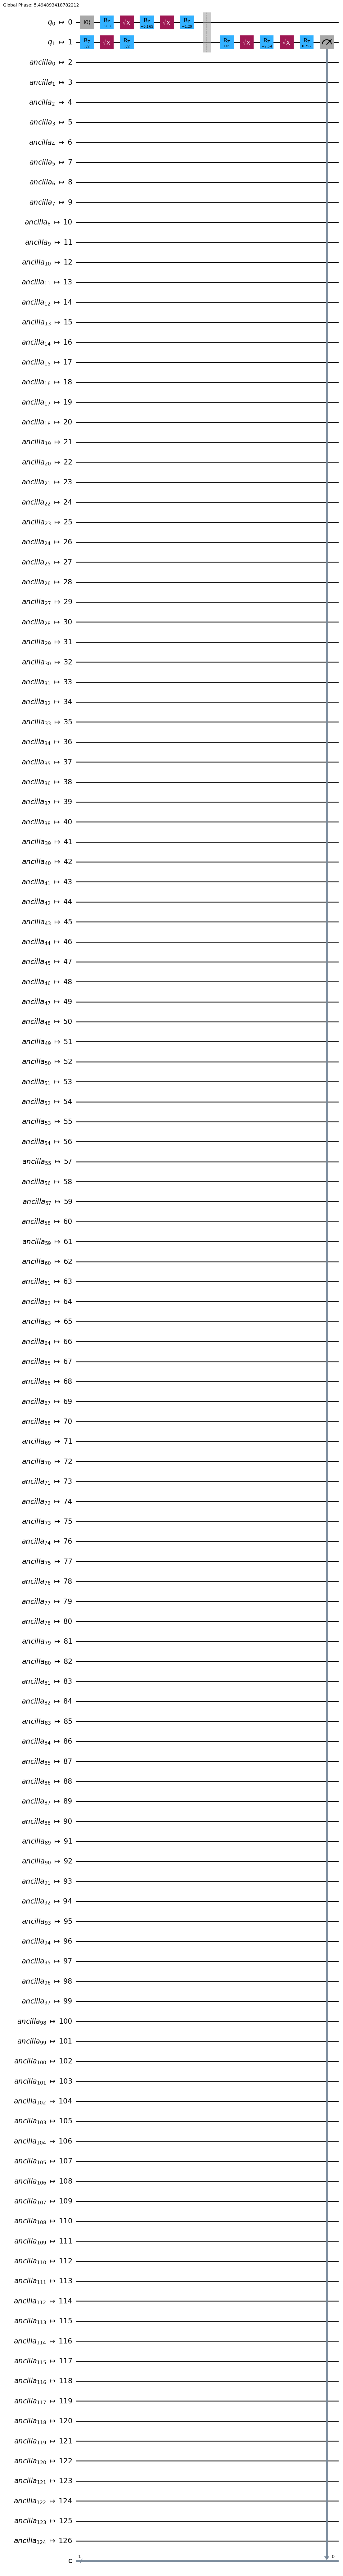

In [29]:
list_of_transpiled_qcs[3].draw(output='mpl', fold=-1)